In [1]:
import pandas as pd
import numpy as np
import statistics as stats

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("../dataset/text/listings_text_cleaned_full.csv")
df = df.fillna('')

In [66]:
len(df[df['description'].str.contains("apartment")])

37100

In [43]:
len(df[df['price'] == 0])

9352

Text mining: 

45,008 records matching listing_name, description, host_about, neighborhood_overview with price. 

 

Domain stop words: Airbnb, room, bed, bedroom, apartment, beach 

 

 

Price needs to be more segmented: 

Private or shared room vs. Entire house/apt 

Low vs. High price (or >$1000/night) 

 

 

=1155 listings text >$1,000/night 

$150 - $300 

$300 - $1000  

Adjectives  

<$150

In [44]:
df.head()

name  \
0            panoramic ocean view venice beach   
1  spanish bungalow guest house la plus nights   
2             boho chic flat steps beach beach   
3            guest house entrance exit hot tub   
4   amazing bright elegant condo park upgraded   

                                         description  \
0  craftsmen style penthouse ocean view rooms par...   
1  private guest house space private guest house ...   
2  bright airy quiet bedroom located steps seclud...   
3  fully self contained separate structure entran...   
4  beach unit upgraded new bamboo flooring brand ...   

                               neighborhood_overview  \
0            close beach live venice boardwalk beach   
1  local la community shops restaurants walking d...   
2  beach locations los angeles peninsula marina d...   
3           close venice hassle parking spaces beach   
4                                                NaN   

                                          host_about  price  
0  yoga practice studying years spend months thai...  152.0  
1  male educated healthcare professional cycle ru...   75.0  
2  health wellness professional author passionate...  125.0  
3  easy going hostess enjoy stay experienced trav...  189.0  
4  paolo privitera ceo evensi paolo mit mba phone...  115.0

In [45]:
df = df[(df['price'] < 1000) & (df['price'] >= 300)].fillna('')

In [46]:
len(df['price'])

1155

#### TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [47]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

column_for_clustering = input("Column for clustering: ")

while column_for_clustering not in list(df.columns):
  column_for_clustering = input("Column entered not in DataFrame. Column for clustering: ")

dtm = tfidf.fit_transform(df[column_for_clustering])

#### Look for best K with elbow chart

In [48]:
number_clusters = range(1,21)

kmeans = [
  KMeans(n_clusters=i, max_iter=100, random_state=69)
  for i in number_clusters
]

kmeans

[KMeans(max_iter=100, n_clusters=1, random_state=69),
 KMeans(max_iter=100, n_clusters=2, random_state=69),
 KMeans(max_iter=100, n_clusters=3, random_state=69),
 KMeans(max_iter=100, n_clusters=4, random_state=69),
 KMeans(max_iter=100, n_clusters=5, random_state=69),
 KMeans(max_iter=100, n_clusters=6, random_state=69),
 KMeans(max_iter=100, n_clusters=7, random_state=69),
 KMeans(max_iter=100, random_state=69),
 KMeans(max_iter=100, n_clusters=9, random_state=69),
 KMeans(max_iter=100, n_clusters=10, random_state=69),
 KMeans(max_iter=100, n_clusters=11, random_state=69),
 KMeans(max_iter=100, n_clusters=12, random_state=69),
 KMeans(max_iter=100, n_clusters=13, random_state=69),
 KMeans(max_iter=100, n_clusters=14, random_state=69),
 KMeans(max_iter=100, n_clusters=15, random_state=69),
 KMeans(max_iter=100, n_clusters=16, random_state=69),
 KMeans(max_iter=100, n_clusters=17, random_state=69),
 KMeans(max_iter=100, n_clusters=18, random_state=69),
 KMeans(max_iter=100, n_clusters=

In [49]:
score = [
  kmeans[i].fit(dtm).score(dtm) for i in range(len(kmeans))
] # this step takes the longest time: 3 mins 25 seconds for me.

score = [i*-1 for i in score] # convert to positive scores

c:\VS_Code\Projects\Airbnb-Research\rio-airbnb-predictive-model\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



best k is: 9


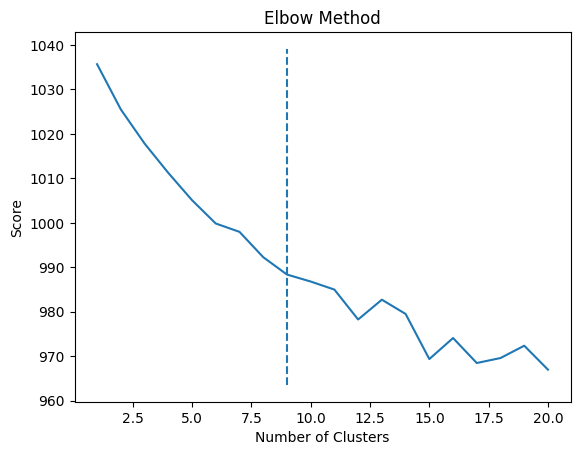

In [50]:
import matplotlib.pyplot as plt

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')

from kneed import KneeLocator
kn = KneeLocator(number_clusters, score, curve='convex', direction='decreasing')
k = kn.knee
print('best k is:', k)

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.show()

#### Create the KMeans Model

In [51]:
type(dtm)

scipy.sparse._csr.csr_matrix

In [52]:
model = KMeans(
  n_clusters=k, init='k-means++', n_init=1, random_state=40
)
model.fit(dtm)

cluster_results_column = f'{column_for_clustering}_clusters'

df[cluster_results_column] = model.labels_

In [68]:
df_name = df[[column_for_clustering, cluster_results_column]]

df_name.head()

KeyError: "['description_clusters'] not in index"

In [54]:
tfidf.get_feature_names_out()

array(['abbot', 'abbott', 'ability', ..., 'zone', 'zones', 'zuma'],
      dtype=object)

In [55]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = tfidf.get_feature_names_out()

cluster_keyterms = []
for i in range(k):
  keyterms = []
  print("Cluster %d:" % i)
  for j in order_centroids[i, :10]: #print out up to 10 feature terms of each cluster
      keyterm = ' %s' % terms[j]
      print (keyterm)
      keyterms.append([keyterm])
  cluster_keyterms.append([[i],keyterms])
  print('------------')
print (cluster_keyterms)

Cluster 0:
 gathering
 sqf
 allowing
 boasting
 comfortably
 southern
 construction
 plan
 entertaining
 designed
------------
Cluster 1:
 floating
 apartment
 soaking
 large
 suite
 en
 closet
 monica
 santa
 spill
------------
Cluster 2:
 heating
 spa
 retreat
 open
 assist
 day
 level
 floorplan
 plan
 stay
------------
Cluster 3:
 upstairs
 unit
 downstairs
 apartment
 sofa
 bed
 queen
 breeze
 size
 brand
------------
Cluster 4:
 amazing
 new
 minium
 natuzzi
 costal
 sublime
 leather
 wireless
 expect
 verde
------------
Cluster 5:
 apartment
 beach
 home
 room
 pool
 house
 space
 hollywood
 private
 bedroom
------------
Cluster 6:
 celebrities
 realize
 driveways
 gonna
 receive
 masseuse
 house
 powered
 tours
 quarter
------------
Cluster 7:
 luxuriant
 levels
 mansion
 book
 high
 private
 rental
 cation
 array
 amenities
------------
Cluster 8:
 imported
 leo
 consisting
 viewing
 premiere
 left
 sexy
 showcase
 stand
 waterfalls
------------
[[[0], [[' gathering'], [' sqf'

In [59]:
# write a function to get the first record in a cluster by the cluster number
def getArticleByCluster(clusterNumber):
  for i in range (0, len(df)-1):
    if (df[cluster_results_column][i] == clusterNumber):
      print (i, df[column_for_clustering][i])
      break

getArticleByCluster(0)  

KeyError: 1

#### Plot clusters with PCA

In [56]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(dtm.toarray())

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]


scatter_df = pd.DataFrame({
  "x": x_axis,
  "y": y_axis,
  "clusters": [f'Cluster {d}' for d in df[cluster_results_column]]
})

fig = px.scatter(scatter_df, x="x", y="y", color="clusters", width=1000, height=1000)
fig.update_layout(
  yaxis_range=(-0.8,0.8),
  xaxis_range=(-0.6,0.8)
)

fig.show()

# # plot legend
# plt.legend(handles=legend_elements, loc='upper right')

In [57]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(5,2)

for i,ax in enumerate(ax_list.flat):
  
  df_per_cluster = df_name[df_name[cluster_results_column] == i]
  
  if len(df_per_cluster) == 0:
    break
  
  wordcloud = WordCloud(
    collocations=False,
    width=1600, height=800,
    background_color='white',
    random_state=42
  ).generate(
    ' '.join(df_per_cluster[column_for_clustering])
  )
  
  ax.imshow(wordcloud)
  ax.axis('off')
  ax.set_title(f'Cluster {i}', size=72)

fig.set_figheight(48 * 4)
fig.set_figwidth(160)
fig.show()

C:\Users\Tran Minh Khoi\AppData\Local\Temp\ipykernel_11768\1972244558.py:28: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [67]:
import statistics

print(f"CLUSTERING PRICE STATISTICS FOR COLUMN '{column_for_clustering.upper()}'\n")

for i in range(k):
  df_per_cluster = df[df[cluster_results_column] == i]
  
  mean = statistics.mean(df_per_cluster[column_for_clustering].to_list())
  median = statistics.median(df_per_cluster[column_for_clustering].to_list())
  deviation = statistics.stdev(df_per_cluster[column_for_clustering].to_list())
  
  print("--------------------------------------------------------")
  print(f"Average price for cluster {i}: {mean}")
  print(f"Median price for cluster {i}: {median}")
  print(f"Standard deviation for cluster {i}: {deviation}\n\n")

CLUSTERING PRICE STATISTICS FOR COLUMN 'DESCRIPTION'



KeyError: 'description_clusters'

In [ ]:
from pandas import isnull


def countToken(text):
  if pd.isnull(text):
    return 0
  else:
    return

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


# Naive Bayes
text_clf_nb = Pipeline([
  ('tfidf', TfidfVectorizer()),
  ('clf', MultinomialNB())
])

## Logistic Regression
text_clf_lr = Pipeline([
  ('tfidf', TfidfVectorizer()),
  ('clf', LogisticRegression())
])

### Linear SVC: ###
text_clf_lsvc = Pipeline([
  ('tfidf', TfidfVectorizer()),
  ('clf', LinearSVC())
])

In [77]:
text_clf_nb.fit(X_train, y_train)
text_clf_lr.fit(X_train, y_train)
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [78]:
pred_nb = text_clf_nb.predict(X_test)

print(metrics.confusion_matrix(y_test,pred_nb))
print(metrics.classification_report(y_test,pred_nb))

[[103  37]
 [ 51 109]]
              precision    recall  f1-score   support

        high       0.67      0.74      0.70       140
         low       0.75      0.68      0.71       160

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.71      0.71      0.71       300



In [79]:
pred_lr = text_clf_lr.predict(X_test)

print(metrics.confusion_matrix(y_test,pred_lr))
print(metrics.classification_report(y_test,pred_lr))

[[104  36]
 [ 46 114]]
              precision    recall  f1-score   support

        high       0.69      0.74      0.72       140
         low       0.76      0.71      0.74       160

    accuracy                           0.73       300
   macro avg       0.73      0.73      0.73       300
weighted avg       0.73      0.73      0.73       300



In [80]:
pred_lsvc = text_clf_lsvc.predict(X_test)

print(metrics.confusion_matrix(y_test,pred_lsvc))
print(metrics.classification_report(y_test,pred_lsvc))

[[ 90  50]
 [ 47 113]]
              precision    recall  f1-score   support

        high       0.66      0.64      0.65       140
         low       0.69      0.71      0.70       160

    accuracy                           0.68       300
   macro avg       0.68      0.67      0.67       300
weighted avg       0.68      0.68      0.68       300



Text(0, 0.5, 'Error Rate')

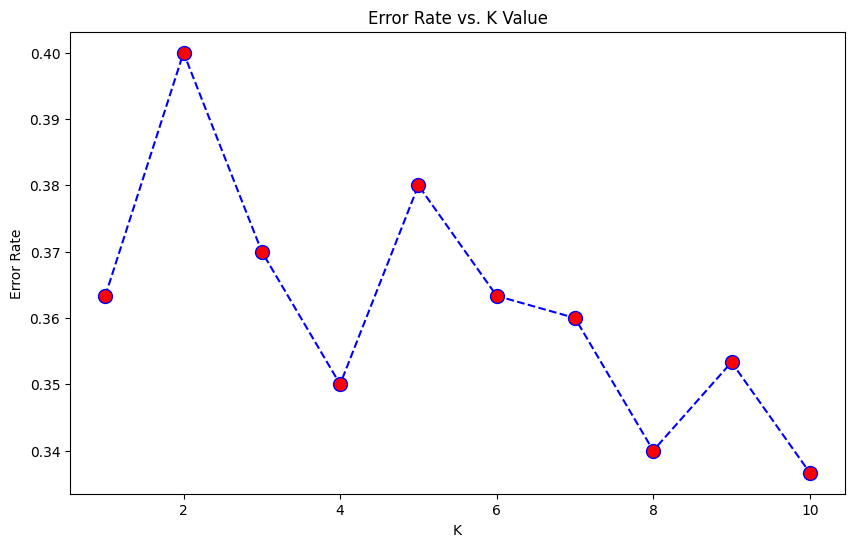

In [81]:
error_rate = []

for i in range(1,11):
  text_clf_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', KNeighborsClassifier(n_neighbors=i))
  ])
  text_clf_knn.fit(X_train, y_train)
  pred_knn = text_clf_knn.predict(X_test)
  error_rate.append(np.mean(pred_knn != y_test))
  
plt.figure(figsize=(10,6))
plt.plot(range(1,11), error_rate, color='blue', linestyle='dashed', marker='o',
markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')